In [2]:
import pandas as pd
import numpy as np
from  graphviz import Source
from scipy import misc
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#### Importar dados para analise
Para iniciar a analise dos dados primeiro necessita-se
importar esse dados, os .csv encontrados abaixo são os dados disponibilizados
[aqui](https://archive.ics.uci.edu/ml/datasets/record+linkage+comparison+patterns).
Após carregar cada um dos dados .csv unimos em um unico frame do pandas.

In [3]:
dataframe = pd.DataFrame()
for x in range(1,11):
    dataframe_name = '../data/block_'+str(x)+'.csv'
    new_dataframe = pd.read_csv(dataframe_name)
    dataframe = pd.concat([dataframe,new_dataframe])

frame = dataframe

#### Exibir Frame
Exibir resultado do merge dos frames..

In [5]:
frame.head()

,id_1,id_2,cmp_fname_c1,cmp_fname_c2,cmp_lname_c1,cmp_lname_c2,cmp_sex,cmp_bd,cmp_bm,cmp_by,cmp_plz,is_match
0,37291,53113,0.833333333333333,?,1.0,?,1,1,1,1,0,True
1,39086,47614,1,?,1.0,?,1,1,1,1,1,True
2,70031,70237,1,?,1.0,?,1,1,1,1,1,True
3,84795,97439,1,?,1.0,?,1,1,1,1,1,True
4,36950,42116,1,?,1.0,1,1,1,1,1,1,True


In [5]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5749132 entries, 0 to 574912
Data columns (total 12 columns):
id_1            int64
id_2            int64
cmp_fname_c1    object
cmp_fname_c2    object
cmp_lname_c1    float64
cmp_lname_c2    object
cmp_sex         int64
cmp_bd          object
cmp_bm          object
cmp_by          object
cmp_plz         object
is_match        bool
dtypes: bool(1), float64(1), int64(3), object(7)
memory usage: 531.8+ MB


É possível observar que os dados numéricos estão em formatos de string

#### Corrigindo tipos de dados

In [4]:
broken_columns = list(frame.columns[2:11])

for column in broken_columns:
    frame[column] = frame[column].apply(lambda x: np.NaN if x == '?' else x)
    frame[column] = frame[column].apply(lambda x: float(x) if type(x) == str else x)

In [5]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5749132 entries, 0 to 574912
Data columns (total 12 columns):
id_1            int64
id_2            int64
cmp_fname_c1    float64
cmp_fname_c2    float64
cmp_lname_c1    float64
cmp_lname_c2    float64
cmp_sex         int64
cmp_bd          float64
cmp_bm          float64
cmp_by          float64
cmp_plz         float64
is_match        bool
dtypes: bool(1), float64(8), int64(3)
memory usage: 531.8 MB


#### Verificando a existência de valores nulos

In [11]:
imp_values = frame.drop(['id_1','id_2','is_match'],axis=1)

In [12]:
melted_frame = pd.melt(imp_values.notnull())

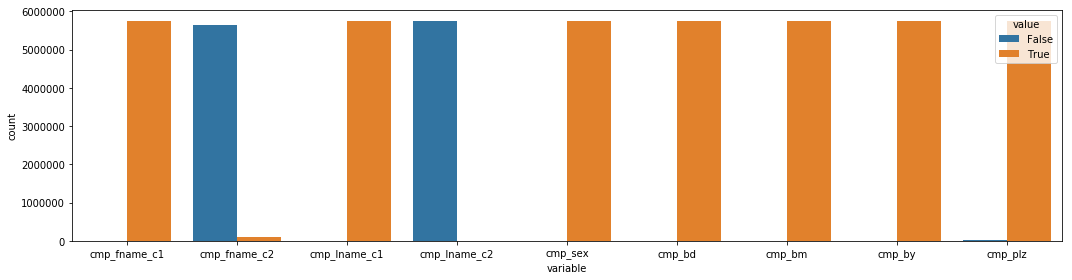

In [13]:
plt.figure(figsize=(15,4))
sns.countplot(melted_frame['variable'],hue=melted_frame['value'])
plt.tight_layout()

No gráfico acima as barras em azul representam o número de valores nulos de cada coluna

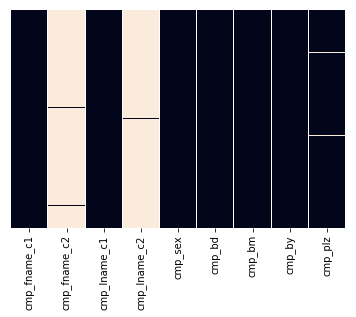

In [14]:
sns.heatmap(imp_values.isnull(),cbar=False,yticklabels=False)

Acima vemos outro gráfico que representa a quantidade de valores nulos de cada coluna. Nesse caso as partes claras
representam os valores faltantes

#### Removendo colunas vazias
Com a visualização dos graficos é possivel observar que as colunas cmp_fname_c2 e cmp_lname_c2, existem muitos dados faltantes, então ele serão desconsideradas a aplicação dos métodos e nas demais colunas onde existem dados faltantes serão preenchidas pelas medias dos valores dos dados;

Removendo colunas desnecessario para aplicar o modelo.

In [6]:
frame.drop(['id_1','id_2','cmp_fname_c2','cmp_lname_c2'],axis=1,inplace=True)

Aplicando as medias para os demais valores faltantes dos frames.

In [7]:
def preparer_data(frame):
    frame["cmp_fname_c1"] = frame["cmp_fname_c1"].replace(np.NaN,0.000235404896421846)
    frame["cmp_lname_c1"] = frame["cmp_lname_c1"].replace(np.NaN,2.68694413843136e-05)
    frame["cmp_sex"] = frame["cmp_sex"].replace(np.NaN,0.5)
    frame["cmp_bd"] = frame["cmp_bd"].replace(np.NaN,0.032258064516129)
    frame["cmp_bm"] = frame["cmp_bm"].replace(np.NaN,0.0833333333333333)
    frame["cmp_by"] = frame["cmp_by"].replace(np.NaN, 0.00943396226415094)
    frame["cmp_plz"] = frame["cmp_plz"].replace(np.NaN, 0.000422654268808115)
    
    return frame

frame = preparer_data(frame)

#### Verificando a existência de valores nulos

In [10]:
frame.isnull().values.any()

False

Ainda para observar, se as demais features que irão realmente compor o modelo, iremos buscar a correlação entre elas,
casos duas features tenham correlação muito alta, deverão ser desconsideradas no modelo, pois elas basicamente estariam 
trazendo a mesma informação ao modelo.

In [11]:
frame.corr()

,cmp_fname_c1,cmp_lname_c1,cmp_sex,cmp_bd,cmp_bm,cmp_by,cmp_plz,is_match
cmp_fname_c1,1.000000,-0.668145,0.151666,0.016742,0.274531,0.033493,0.031607,0.044168
cmp_lname_c1,-0.668145,1.000000,0.109754,-0.210898,-0.392630,-0.219032,0.101822,0.123234
cmp_sex,0.151666,0.109754,1.000000,-0.242386,-0.151130,-0.239898,0.008734,0.009416
cmp_bd,0.016742,-0.210898,-0.242386,1.000000,-0.183648,0.072568,0.085247,0.111908
cmp_bm,0.274531,-0.392630,-0.151130,-0.183648,1.000000,-0.181056,0.045027,0.061539
cmp_by,0.033493,-0.219032,-0.239898,0.072568,-0.181056,1.000000,0.086154,0.112324
cmp_plz,0.031607,0.101822,0.008734,0.085247,0.045027,0.086154,1.000000,0.776620
is_match,0.044168,0.123234,0.009416,0.111908,0.061539,0.112324,0.776620,1.000000


Partindo da tabela de correlação podemos intenficar, que os dados estão bem desacoplados, sendo assim podemos utiliza-los no nosso modelo. Por padrão a correlação que o pandas implementa é a correlação de pearson, onde:


$\rho = 1$ - Significa a existência de uma correlação perfeita e positiva entre duas variáveis.

$\rho = -1$ - Significa a existência de uma correlação perfeita e negativa entre duas variáveis, ou seja são inversamente proporcionais.

$\rho = 0$ - Significa que as variáveis não dependem linearmente uma da outra.

Para melhor visualizar a correlação dos dados o seguinte gráfico foi gerado:

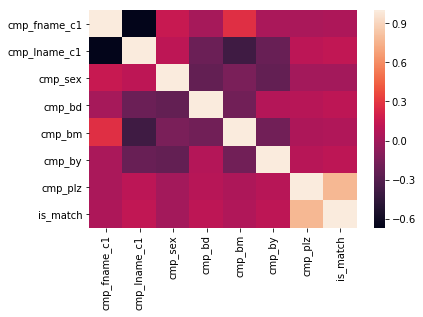

In [8]:
sns.heatmap(frame.corr())

Após esse tramento dos dados, as features abaixo serão as que vão incorporar o modelo.

In [12]:
frame.head()

,cmp_fname_c1,cmp_lname_c1,cmp_sex,cmp_bd,cmp_bm,cmp_by,cmp_plz,is_match
0,0.833333,1.0,1,1.0,1.0,1.0,0.0,True
1,1.000000,1.0,1,1.0,1.0,1.0,1.0,True
2,1.000000,1.0,1,1.0,1.0,1.0,1.0,True
3,1.000000,1.0,1,1.0,1.0,1.0,1.0,True
4,1.000000,1.0,1,1.0,1.0,1.0,1.0,True


# Neural Network

Após todo o tratamento dos dados a solução utilizando redes neurais foi implementada nos passos a seguir.

Insere a coluna de resultados (**is_match**) na variável `y`.

In [13]:
y = frame['is_match']

Remove a coluna **is_match** para que após o treinamento o resultado gerado seja comparado com a coluna y (**is_match**) e insere na variável X.

In [14]:
X = frame.drop(['is_match'],axis=1)

Separando os valores de *test* e *train*. sendo 33% para teste.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Imprime a quantidade de colunas para dimensionar *hidden layer*.

In [19]:
X.axes

[Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                  8,      9,
             ...
             574903, 574904, 574905, 574906, 574907, 574908, 574909, 574910,
             574911, 574912],
            dtype='int64', length=5749132),
 Index(['cmp_fname_c1', 'cmp_lname_c1', 'cmp_sex', 'cmp_bd', 'cmp_bm', 'cmp_by',
        'cmp_plz'],
       dtype='object')]

Configurando as dimensões da rede neural para uma matriz 10x7.

In [20]:
clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10,7), random_state=1)

Aplicando método `fit`, que tem por objetivo ajustar o modelo aos dados X e y.

In [21]:
clf.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 7), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

Identificando os pesos da rede depois do treinamento.

In [28]:
print("Quantidade de camadas da rede", len(clf.coefs_))
print("Peso da camanda 0 =", len(clf.coefs_[0]))
print("Peso da camanda 1 =", len(clf.coefs_[1]))
print("Peso da camanda 2 =", len(clf.coefs_[2]))

Quantidade de camadas da rede 3
Peso da camanda 0 = 7
Peso da camanda 1 = 10
Peso da camanda 2 = 7


In [29]:
len(clf.intercepts_[0])

10

Executando o método `predict` a rede neural é usada para predizer o resultado dos dados. 

In [30]:
result = clf.predict(X_test)

## Teste

Matriz de confusão

In [31]:
print(confusion_matrix(y_test, result))

[[1890302      35]
 [     29    6848]]


Resultados:

In [32]:
print(classification_report(y_test, result))

             precision    recall  f1-score   support

      False       1.00      1.00      1.00   1890337
       True       0.99      1.00      1.00      6877

avg / total       1.00      1.00      1.00   1897214

